# import libraries


In [3]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.2 MB/s 


In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import catboost
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

#upload data

In [130]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

# train = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/train.csv')
# test = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/test.csv')

#data processing

In [131]:
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [132]:
train.sample(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
4208,1,19.05,19.05,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
2528,28,89.90,2433.5,Female,0,Yes,No,Yes,No,Fiber optic,No,Yes,Yes,No,No,Yes,Month-to-month,No,Credit card (automatic),0
696,47,99.35,4749.15,Male,0,Yes,Yes,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,1
1197,47,26.90,1250.85,Female,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Electronic check,0
1810,3,74.75,229.5,Female,0,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),1


In [133]:
train.describe()

,ClientPeriod,MonthlySpending,IsSeniorCitizen,Churn
count,5282.000000,5282.000000,5282.000000,5282.000000
mean,32.397009,64.924754,0.159409,0.262022
std,24.550326,30.176464,0.366092,0.439776
min,0.000000,18.250000,0.000000,0.000000
25%,9.000000,35.462500,0.000000,0.000000
50%,29.000000,70.400000,0.000000,0.000000
75%,55.000000,90.050000,0.000000,1.000000
max,72.000000,118.750000,1.000000,1.000000


In [134]:
#drop nan
train['TotalSpent'].value_counts(dropna=False).sort_values(ascending=False).head(3)

         9
20.2     9
19.75    8
Name: TotalSpent, dtype: int64

there are  9 empty **strings**, convert all data to float and drop *nan*:

In [135]:
train['TotalSpent'] = train['TotalSpent'].replace(r'^\s*$', 
                                                np.nan, regex=True).astype('float')
train['TotalSpent'] = train['TotalSpent'].replace(r'^\s*$', 
                                                np.nan, regex=True).astype('float')
train = train[train['TotalSpent'].notna()]

In [136]:
#check NaN
train.isna().mean()

ClientPeriod                0.0
MonthlySpending             0.0
TotalSpent                  0.0
Sex                         0.0
IsSeniorCitizen             0.0
HasPartner                  0.0
HasChild                    0.0
HasPhoneService             0.0
HasMultiplePhoneNumbers     0.0
HasInternetService          0.0
HasOnlineSecurityService    0.0
HasOnlineBackup             0.0
HasDeviceProtection         0.0
HasTechSupportAccess        0.0
HasOnlineTV                 0.0
HasMovieSubscription        0.0
HasContractPhone            0.0
IsBillingPaperless          0.0
PaymentMethod               0.0
Churn                       0.0
dtype: float64

There are no pass



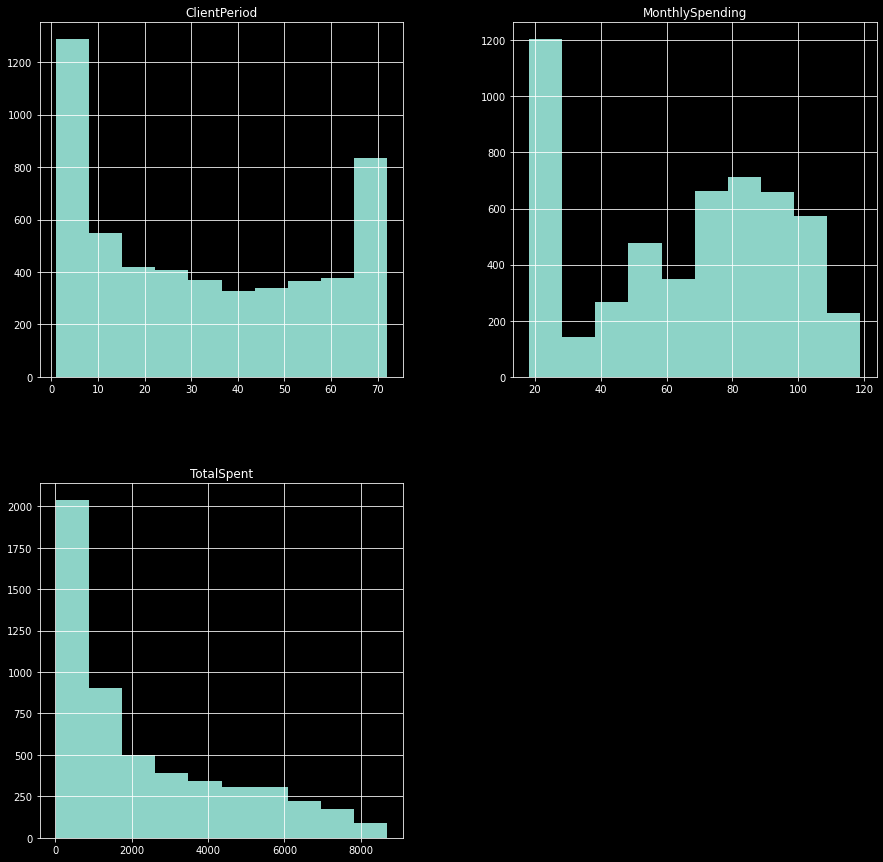

In [137]:
#numerical features
plt.style.use('dark_background')
train[num_cols].hist(figsize = (15, 15))
None

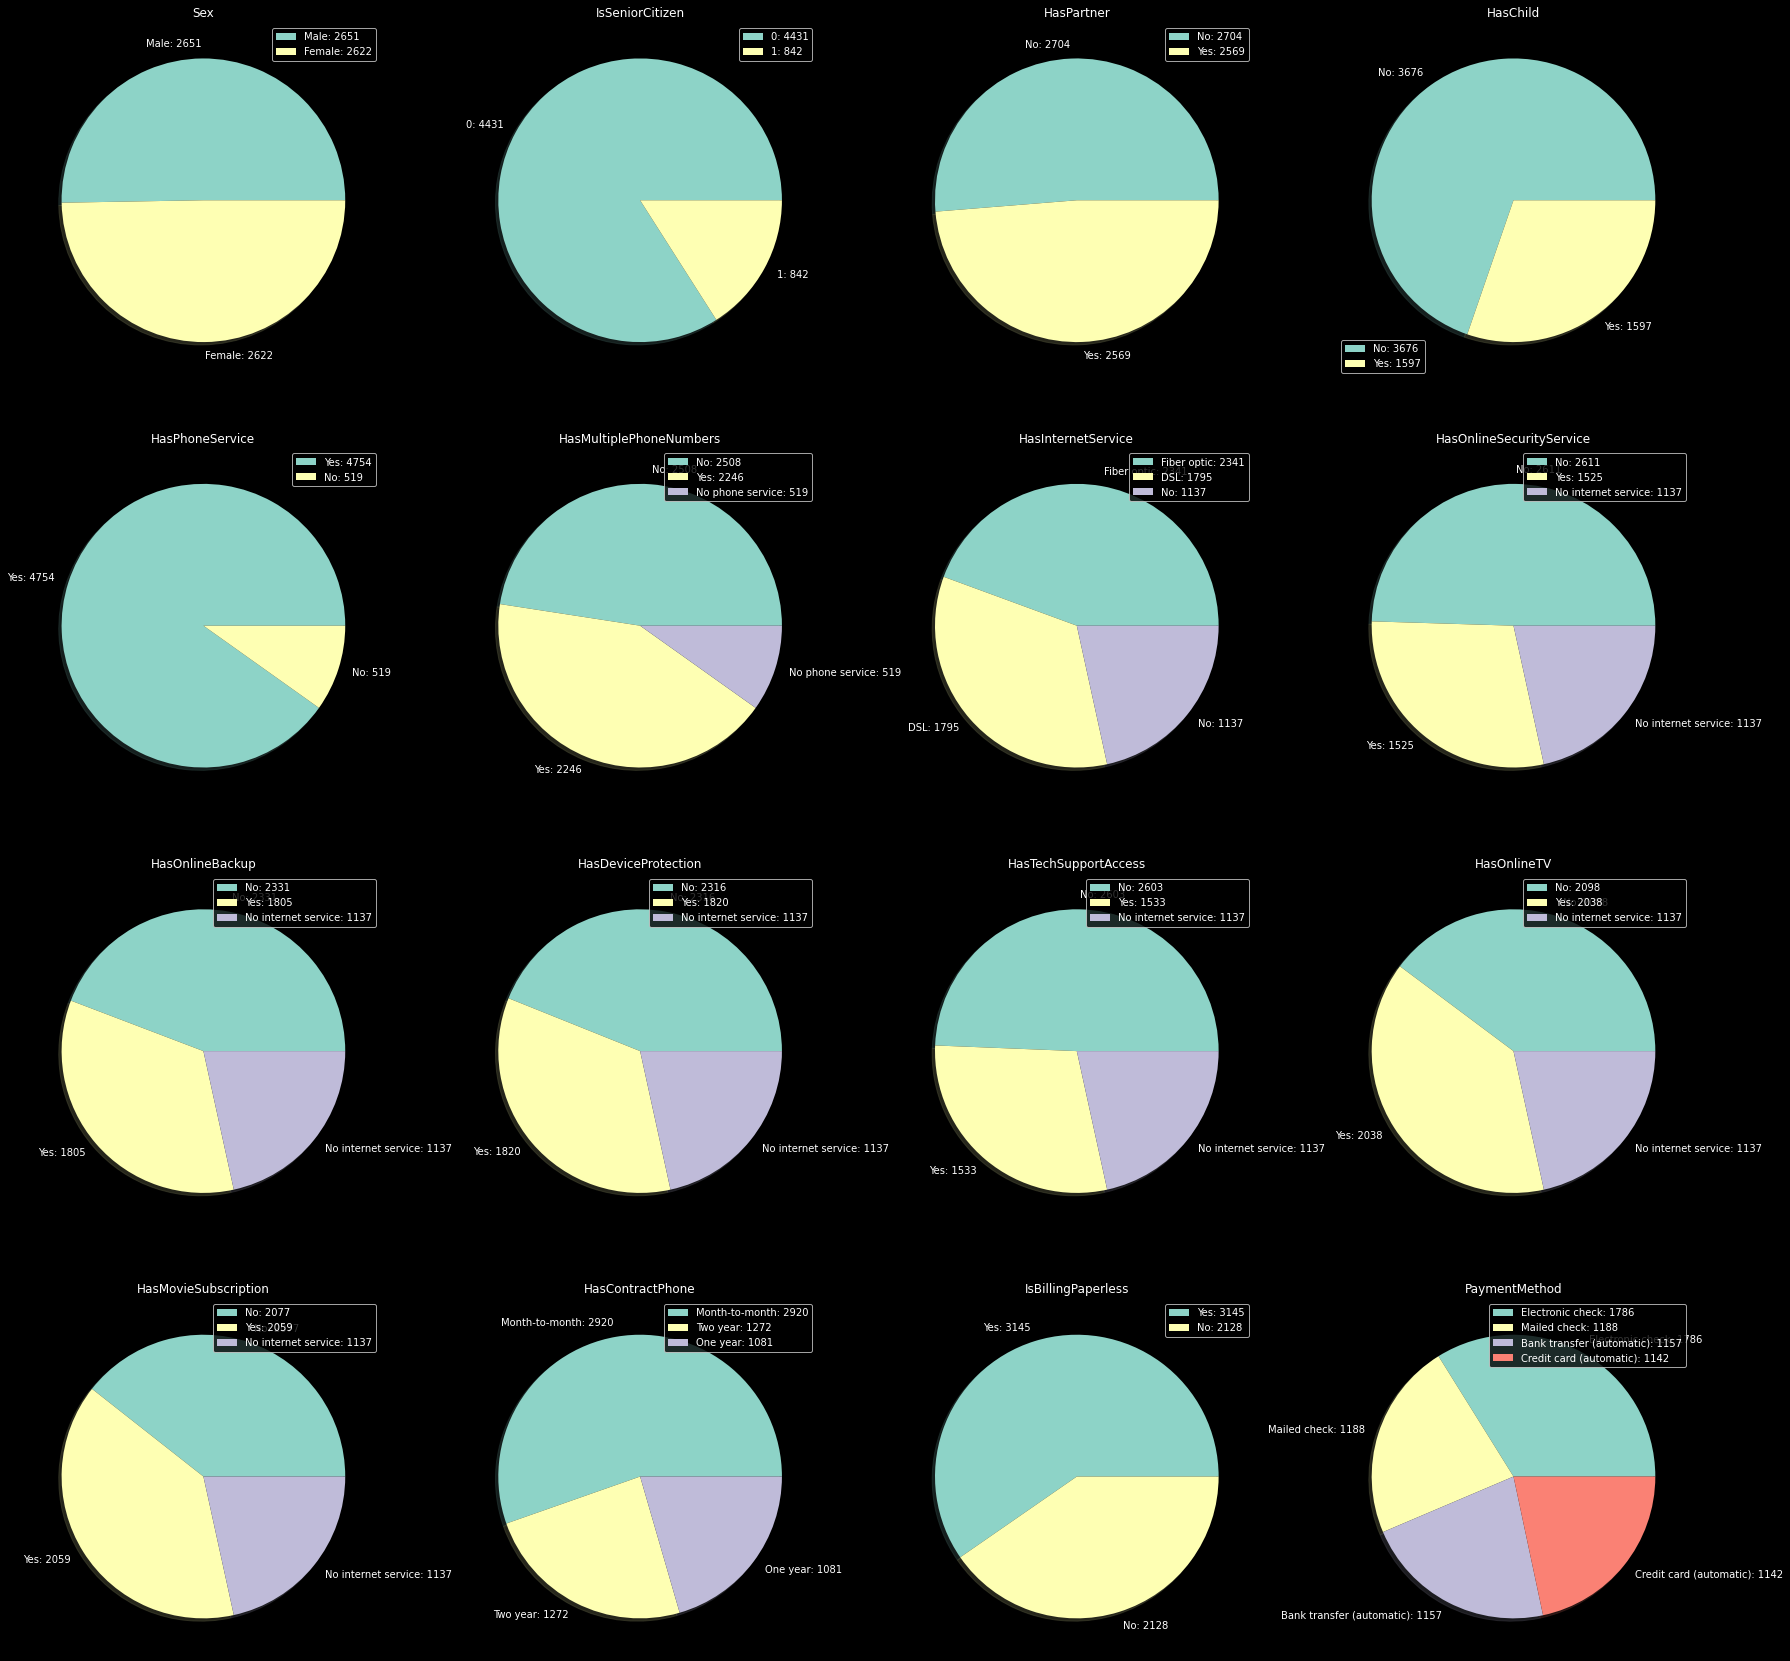

In [138]:
#categorical features
plt.figure(figsize = (30, 30))
for idx, col in enumerate(cat_cols):
    ax = plt.subplot(4, 4, idx + 1)
    plot_data = train[col].value_counts().to_numpy()
    plot_labels = (train[col].value_counts().index).astype(str) + ': ' + plot_data.astype(str)
    plt.pie(plot_data, labels = plot_labels, shadow = True)
    plt.title(col)
    plt.legend()

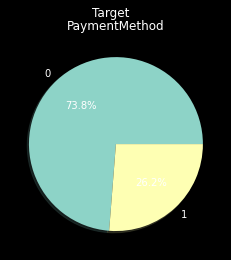

In [139]:
fig, axes = plt.subplots()
fig.suptitle("Target")
column_values = train[target_col].value_counts()
labels = column_values.index
sizes = column_values.values
axes.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True)
axes.set_title(col)
plt.show()

as you can see from the chart the data is balanced

#correlation

In [140]:
!pip install phik

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [141]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

interval columns not set, guessing: ['ClientPeriod', 'MonthlySpending', 'TotalSpent', 'IsSeniorCitizen', 'Churn']


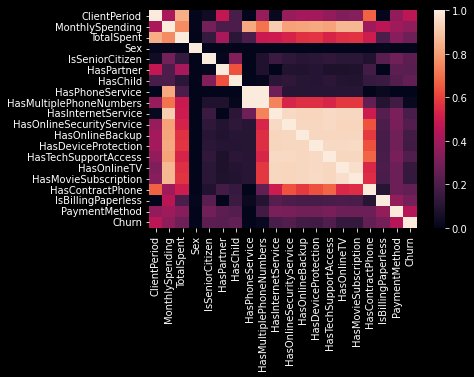

In [142]:
phik_overview = train.phik_matrix()
sns.heatmap(phik_overview)
None

#logistic regression


In [143]:
#one-hot encoding
X = pd.concat([train[num_cols], pd.get_dummies(train[cat_cols])], axis=1).copy()

In [144]:
X

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Sex_Female,Sex_Male,HasPartner_No,HasPartner_Yes,HasChild_No,HasChild_Yes,...,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,55,19.50,1026.35,0,0,1,0,1,0,1,...,0,0,1,0,1,0,0,0,0,1
1,72,25.85,1872.20,0,0,1,0,1,1,0,...,0,0,0,1,1,0,0,1,0,0
2,1,75.90,75.90,0,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0
3,32,79.30,2570.00,1,1,0,0,1,1,0,...,0,1,0,0,1,0,0,0,0,1
4,60,115.25,6758.45,0,1,0,0,1,0,1,...,1,0,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5277,3,30.40,82.15,0,0,1,1,0,1,0,...,0,1,0,0,1,0,0,0,1,0
5278,50,44.45,2188.45,0,0,1,0,1,1,0,...,0,0,1,0,0,1,1,0,0,0
5279,1,55.05,55.05,0,0,1,1,0,1,0,...,0,1,0,0,1,0,0,0,0,1
5280,29,76.00,2215.25,0,1,0,1,0,1,0,...,0,1,0,0,0,1,0,1,0,0


In [145]:
X.shape

(5273, 45)

In [146]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [147]:
#split
y = train[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [148]:
lr_model = LogisticRegressionCV()
lr_model.fit(X_train, y_train)
lr_model.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [149]:
cls = make_pipeline(StandardScaler(),LogisticRegression())
param_grid = {'logisticregression__C': np.array([100, 10, 1, 0.1, 0.01, 0.001])}
search = GridSearchCV(cls, param_grid, n_jobs=-1, cv=5, refit=True, scoring='roc_auc')
search.fit(X_train, y_train)
print(search.best_params_)
print(search.best_score_)
print(search.best_estimator_)

{'logisticregression__C': 10.0}
0.8447388460416845
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=10.0))])


#gradient boosting




In [151]:
#split
X_train, X_test, y_train, y_test = train_test_split(train[feature_cols], train[target_col], train_size=0.8, random_state=42)

In [152]:
boosting_model = catboost.CatBoostClassifier(n_estimators=200, 
                                             cat_features=cat_cols)

boosting_model.fit(X_train, y_train)

y_train_pred = boosting_model.predict_proba(X_train)[:, 1]
y_test_pred = boosting_model.predict_proba(X_test)[:, 1]

Learning rate set to 0.083332
0:	learn: 0.6393850	total: 19.6ms	remaining: 3.89s
1:	learn: 0.5986678	total: 35.2ms	remaining: 3.48s
2:	learn: 0.5669397	total: 47.1ms	remaining: 3.1s
3:	learn: 0.5401092	total: 66.4ms	remaining: 3.25s
4:	learn: 0.5184259	total: 81.7ms	remaining: 3.19s
5:	learn: 0.5006508	total: 96.6ms	remaining: 3.12s
6:	learn: 0.4860068	total: 109ms	remaining: 3.01s
7:	learn: 0.4729220	total: 123ms	remaining: 2.96s
8:	learn: 0.4613053	total: 138ms	remaining: 2.93s
9:	learn: 0.4518849	total: 153ms	remaining: 2.9s
10:	learn: 0.4444709	total: 167ms	remaining: 2.87s
11:	learn: 0.4389258	total: 181ms	remaining: 2.84s
12:	learn: 0.4351742	total: 193ms	remaining: 2.78s
13:	learn: 0.4308061	total: 211ms	remaining: 2.8s
14:	learn: 0.4263292	total: 233ms	remaining: 2.87s
15:	learn: 0.4224699	total: 247ms	remaining: 2.84s
16:	learn: 0.4199115	total: 260ms	remaining: 2.79s
17:	learn: 0.4175362	total: 272ms	remaining: 2.75s
18:	learn: 0.4142761	total: 288ms	remaining: 2.74s
19:	lear

In [153]:
roc_auc_score(y_train, y_train_pred)

0.8892021530104204

In [154]:
roc_auc_score(y_test, y_test_pred)

0.8397499410238264

need to find best hyperparameters

In [155]:
params = {'iterations':[200, 300, 400], 
          'learning_rate':[0.1, 0.2], 'depth':[2, 3, 4, 5, 7]} 
model_with_grid = catboost.CatBoostClassifier(cat_features=cat_cols, 
                                              random_seed=42, verbose=False)
best_model = model_with_grid.grid_search(params, X_train, y=y_train)


bestTest = 0.4051994776
bestIteration = 175

0:	loss: 0.4051995	best: 0.4051995 (0)	total: 941ms	remaining: 27.3s

bestTest = 0.4053888551
bestIteration = 83

1:	loss: 0.4053889	best: 0.4051995 (0)	total: 1.9s	remaining: 26.6s

bestTest = 0.4051994776
bestIteration = 175

2:	loss: 0.4051995	best: 0.4051995 (0)	total: 3.27s	remaining: 29.4s

bestTest = 0.4053888551
bestIteration = 83

3:	loss: 0.4053889	best: 0.4051995 (0)	total: 4.68s	remaining: 30.4s

bestTest = 0.4051994776
bestIteration = 175

4:	loss: 0.4051995	best: 0.4051995 (0)	total: 6.53s	remaining: 32.6s

bestTest = 0.4053888551
bestIteration = 83

5:	loss: 0.4053889	best: 0.4051995 (0)	total: 8.98s	remaining: 35.9s

bestTest = 0.4046856833
bestIteration = 168

6:	loss: 0.4046857	best: 0.4046857 (6)	total: 10.4s	remaining: 34s

bestTest = 0.4077336134
bestIteration = 38

7:	loss: 0.4077336	best: 0.4046857 (6)	total: 11.7s	remaining: 32.1s

bestTest = 0.4046856833
bestIteration = 168

8:	loss: 0.4046857	best: 0.4046857 (6)	to

In [156]:
y_train_pred = boosting_model.predict_proba(X_train)[:, 1]
y_test_pred = boosting_model.predict_proba(X_test)[:, 1]

In [157]:
print(f'Best train score: {roc_auc_score(y_train, y_train_pred)}')
print(f'Best test score: {roc_auc_score(y_test, y_test_pred)}')
print(f'Best params: {best_model["params"]}')

Best train score: 0.8892021530104204
Best test score: 0.8397499410238264
Best params: {'depth': 3, 'iterations': 200, 'learning_rate': 0.1}


In [158]:
roc_auc_score(y_train, model_with_grid.predict_proba(X_train)[:, 1])

0.8629013180421626

#Prediction

In [159]:
best_model = catboost.CatBoostClassifier(iterations=300, depth=2, learning_rate = 0.1)

In [160]:
best_model.fit(X_train, y_train, cat_features=cat_cols)

0:	learn: 0.6473828	total: 6.35ms	remaining: 1.9s
1:	learn: 0.6131666	total: 12.6ms	remaining: 1.88s
2:	learn: 0.5834921	total: 18ms	remaining: 1.78s
3:	learn: 0.5608655	total: 23.2ms	remaining: 1.71s
4:	learn: 0.5363024	total: 27.8ms	remaining: 1.64s
5:	learn: 0.5181158	total: 33.4ms	remaining: 1.64s
6:	learn: 0.5015901	total: 38.1ms	remaining: 1.59s
7:	learn: 0.4892030	total: 43.5ms	remaining: 1.59s
8:	learn: 0.4799413	total: 48.6ms	remaining: 1.57s
9:	learn: 0.4713860	total: 53.9ms	remaining: 1.56s
10:	learn: 0.4633496	total: 58.3ms	remaining: 1.53s
11:	learn: 0.4567612	total: 63.1ms	remaining: 1.51s
12:	learn: 0.4519985	total: 68ms	remaining: 1.5s
13:	learn: 0.4477258	total: 72.2ms	remaining: 1.48s
14:	learn: 0.4432160	total: 76.9ms	remaining: 1.46s
15:	learn: 0.4399473	total: 81.7ms	remaining: 1.45s
16:	learn: 0.4377641	total: 86.5ms	remaining: 1.44s
17:	learn: 0.4352600	total: 91.2ms	remaining: 1.43s
18:	learn: 0.4334631	total: 95.5ms	remaining: 1.41s
19:	learn: 0.4320799	total: 

In [161]:
test['TotalSpent'] = pd.to_numeric(X_test['TotalSpent'], errors='coerce')
#submission = pd.read_csv('../input/advanced-dls-spring-2021/submission.csv')
submission = pd.read_csv('./submission.csv')
submission['Churn'] = model_with_grid.predict_proba(test)[:, 1]
submission.to_csv('./my_submission.csv', index=False)